In [6]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import os
import torch
import torchvision as tv
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import time
import cv2
import random
import glob
import nibabel as nib
import skimage
import sklearn
from sklearn import model_selection

In [10]:
### HYPER PARAMETER ###

RANDOM_SEED = 831
IMAGE_SIZE = (128,128) ###(128, 128, 128) => (128,128)로 수정되어야 하지 않나 
BATCH_SIZE = 2
NUM_CLASS = 2
EPOCHS = 200
test_ratio, val_ratio = 0.1, 0.2
    
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = 'cpu'

In [ ]:
# Data불러오기, Preprocessing

In [11]:
images = os.listdir("../input/lung-mask-image-dataset/ChestXray/train/image")
masks = os.listdir("../input/lung-mask-image-dataset/ChestXray/train/mask")

In [12]:
v_images = os.listdir("../input/lung-mask-image-dataset/ChestXray/val/image")
v_masks = os.listdir("../input/lung-mask-image-dataset/ChestXray/val/mask")

In [13]:
print(len(images)==len(masks))
print(len(v_images)==len(v_masks))

True
True


In [14]:
masks.sort()
images.sort()
v_masks.sort()
v_images.sort()

In [15]:
import random

i = random.randint(0,len(images)-1)
img = np.asarray(Image.open(os.path.join("../input/lung-mask-image-dataset/ChestXray/train/image",images[i])))
mask = np.asarray(Image.open(os.path.join("../input/lung-mask-image-dataset/ChestXray/train/mask",masks[i])))
print(img.shape,mask.shape)

(512, 512, 4) (512, 512, 3)


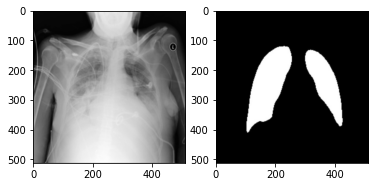

In [16]:
plt.subplot(1,2,1)
plt.imshow(img[:,:,:3]) #rgba to rgb

plt.subplot(1,2,2)
plt.imshow(mask)

plt.show()

In [ ]:
#학습할 수 있는 형태로 dataloader에 올리기

In [17]:

def make_dataset(validation=False):
    x = []
    y = []
    if(validation):
        for i,(image,mask) in enumerate(zip(v_images[:1500],v_masks[:1500])):
            print("\r"+str(i+1)+"/"+str(len(v_images)),end="")

            image = Image.open(os.path.join("../input/lung-mask-image-dataset/ChestXray/val/image",image)).convert('L')
            mask = Image.open(os.path.join("../input/lung-mask-image-dataset/ChestXray/val/mask",mask)).convert('L')

            image = np.asarray(image.resize((128,128)))/255.
            mask = np.asarray(mask.resize((128,128)))/255.

            x.append(image)
            y.append(mask)
    else:
        for i,(image,mask) in enumerate(zip(images[:3500],masks[:3500])):
            print("\r"+str(i+1)+"/"+str(len(images)),end="")

            image = Image.open(os.path.join("../input/lung-mask-image-dataset/ChestXray/train/image",image)).convert('L')
            mask = Image.open(os.path.join("../input/lung-mask-image-dataset/ChestXray/train/mask",mask)).convert('L')

            image = np.asarray(image.resize((128,128)))/255.
            mask = np.asarray(mask.resize((128,128)))/255.

            x.append(image)
            y.append(mask)
    return np.array(x),np.array(y)

In [18]:
train_images,train_labels = make_dataset()

3500/16932

In [19]:
train_images[0].shape
train_images.shape

(3500, 128, 128)

In [20]:
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [21]:
train_data = TensorData(train_images,train_labels)
train_loader = DataLoader(train_data, batch_size= 10)

In [22]:
train_data[0][0].size()

torch.Size([128, 128])

In [23]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [24]:
train_data[0]

(tensor([[0.2784, 0.1765, 0.0745,  ..., 0.0157, 0.0157, 0.0157],
         [0.2745, 0.1804, 0.0824,  ..., 0.0157, 0.0196, 0.0196],
         [0.2706, 0.1765, 0.0863,  ..., 0.0196, 0.0196, 0.0196],
         ...,
         [0.2314, 0.1569, 0.1373,  ..., 0.1216, 0.1176, 0.1137],
         [0.2588, 0.1843, 0.1725,  ..., 0.1725, 0.1686, 0.1725],
         [0.3529, 0.2667, 0.2471,  ..., 0.2196, 0.2196, 0.2235]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [25]:
images[0]

tensor([[0.2784, 0.1765, 0.0745,  ..., 0.0157, 0.0157, 0.0157],
        [0.2745, 0.1804, 0.0824,  ..., 0.0157, 0.0196, 0.0196],
        [0.2706, 0.1765, 0.0863,  ..., 0.0196, 0.0196, 0.0196],
        ...,
        [0.2314, 0.1569, 0.1373,  ..., 0.1216, 0.1176, 0.1137],
        [0.2588, 0.1843, 0.1725,  ..., 0.1725, 0.1686, 0.1725],
        [0.3529, 0.2667, 0.2471,  ..., 0.2196, 0.2196, 0.2235]])

In [26]:
labels[0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [27]:
v_x,v_y = make_dataset(True)

1500/2117

In [ ]:
#UNETR 모델 구현 여기서부터!!

In [31]:
pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 525.5 kB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [33]:
import torch.nn as nn
import torch.nn.functional as F
import math
import einops
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torch import Tensor

class SingleDeconv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super().__init__()
        self.block = nn.ConvTranspose3d(in_planes, out_planes, kernel_size=2, stride=2, padding=0, output_padding=0)

    def forward(self, x):
        return self.block(x)


class SingleConv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size):
        super().__init__()
        self.block = nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, stride=1,
                               padding=((kernel_size - 1) // 2))

    def forward(self, x):
        return self.block(x)


class Conv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleConv3DBlock(in_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)
    
    
class Deconv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleDeconv3DBlock(in_planes, out_planes),
            SingleConv3DBlock(out_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)    

class Embeddings(nn.Module):
    def __init__(self, input_shape, patch_size=16, embed_dim=768, dropout=0.):
        super().__init__()
        self.patch_size = patch_size
        self.in_channels = input_shape[-4]
        self.n_patches = ###int((input_shape[-1] * input_shape[-2] * input_shape[-3]) / (patch_size * patch_size * patch_size))
        self.embed_dim = embed_dim
        self.patch_embeddings = nn.Conv3d(in_channels=self.in_channels, out_channels=self.embed_dim,
                                          kernel_size=self.patch_size, stride=self.patch_size)
        self.position_embeddings = nn.Parameter(torch.zeros(1, self.n_patches, self.embed_dim))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.patch_embeddings(x)
        ###x = rearrange(x, "b n h w d -> b (h w d) n")
        # batch, embed_dim, height/patch, width/patch, depth/patch
        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings

class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        ###qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy / scaling, dim=-1)
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        ###out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out
    
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int = 768, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)
    
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=768, num_heads=8, depth=12, dropout=0., extract_layers=[3,6,9,12]):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(embed_dim, MultiHeadAttention(embed_dim, num_heads, dropout)),
                PreNorm(embed_dim, FeedForwardBlock(embed_dim, expansion=4))
            ]))            
        self.extract_layers = extract_layers
        
    def forward(self, x):
        extract_layers = []
        
        for cnt, (attn, ff) in enumerate(self.layers):
            x = attn(x) + x
            x = ff(x) + x
            if cnt+1 in self.extract_layers:
                extract_layers.append(x)
            
        return extract_layers

class UNETR(nn.Module):
    def __init__(self, ###img_shape=(224, 224, 224), input_dim=3, output_dim=3, 
                 embed_dim=768, patch_size=16, num_heads=8, dropout=0.1, light_r=4):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embed_dim = embed_dim
        self.img_shape = img_shape
        self.patch_size = patch_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.num_layers = 12
        self.ext_layers = [3, 6, 9, 12]

        self.patch_dim = [int(x / patch_size) for x in img_shape]
        self.conv_channels = [int(i/light_r) for i in [32, 64, 128, 256, 512, 1024]]

        self.embedding = Embeddings((input_dim,*img_shape))

        # Transformer Encoder
        self.transformer = \
            TransformerBlock(
            )

        # U-Net Decoder
        self.decoder0 = \
            nn.Sequential(
                Conv3DBlock(input_dim, self.conv_channels[0], 3),
                Conv3DBlock(self.conv_channels[0], self.conv_channels[1], 3)
            )

        self.decoder3 = \
            nn.Sequential(
            Deconv3DBlock(embed_dim, self.conv_channels[2]),
            Deconv3DBlock(self.conv_channels[2], self.conv_channels[2]),
            Deconv3DBlock(self.conv_channels[2], self.conv_channels[2])
            )

        self.decoder6 = \
            nn.Sequential(
                Deconv3DBlock(embed_dim, self.conv_channels[3]),
                Deconv3DBlock(self.conv_channels[3], self.conv_channels[3]),
            )

        self.decoder9 = \
            Deconv3DBlock(embed_dim, self.conv_channels[4])

        self.decoder12_upsampler = \
            SingleDeconv3DBlock(embed_dim, self.conv_channels[4])

        self.decoder9_upsampler = \
            nn.Sequential(
                Conv3DBlock(self.conv_channels[5], self.conv_channels[3]),
                Conv3DBlock(self.conv_channels[3], self.conv_channels[3]),
                Conv3DBlock(self.conv_channels[3], self.conv_channels[3]),
                SingleDeconv3DBlock(self.conv_channels[3], self.conv_channels[3])
            )

        self.decoder6_upsampler = \
            nn.Sequential(
                Conv3DBlock(self.conv_channels[4], self.conv_channels[2]),
                Conv3DBlock(self.conv_channels[2], self.conv_channels[2]),
                SingleDeconv3DBlock(self.conv_channels[2], self.conv_channels[2])
            )

        self.decoder3_upsampler = \
            nn.Sequential(
                Conv3DBlock(self.conv_channels[3], self.conv_channels[1]),
                Conv3DBlock(self.conv_channels[1], self.conv_channels[1]),
                SingleDeconv3DBlock(self.conv_channels[1], self.conv_channels[1])
            )

        self.decoder0_header = \
            nn.Sequential(
                Conv3DBlock(self.conv_channels[2], self.conv_channels[1]),
                Conv3DBlock(self.conv_channels[1], self.conv_channels[1]),
                SingleConv3DBlock(self.conv_channels[1], output_dim, 1)
            )
            
    def forward(self, x):
        z0 = x
        x = self.embedding(x)
        z = self.transformer(x)
        z3, z6, z9, z12 = z
        z3 = z3.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z6 = z6.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z9 = z9.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z12 = z12.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)

        z12 = self.decoder12_upsampler(z12)
        z9 = self.decoder9(z9)
        z9 = self.decoder9_upsampler(torch.cat([z9, z12], dim=1))
        z6 = self.decoder6(z6)
        z6 = self.decoder6_upsampler(torch.cat([z6, z9], dim=1))
        z3 = self.decoder3(z3)
        z3 = self.decoder3_upsampler(torch.cat([z3, z6], dim=1))
        z0 = self.decoder0(z0)
        output = self.decoder0_header(torch.cat([z0, z3], dim=1))
        return output

        

In [ ]:
model = UNETR(img_shape=IMAGE_SIZE, input_dim=1, output_dim=2, 
              embed_dim=768, patch_size=16, num_heads=8, dropout=0., light_r=4)
model = model.to(DEVICE)
model_summary(model, (1,*IMAGE_SIZE), device=DEVICE.type)

In [ ]:
#Loss, optimizer 

In [ ]:
from monai.losses import DiceCELoss, DiceLoss

torch.backends.cudnn.benchmark = True 

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

criterion = monai.losses.DiceLoss(include_background=False, to_onehot_y=False, softmax=True)
MetricDice = monai.metrics.DiceMetric(include_background=False, reduction="mean")

In [ ]:
#모델 학습 및 평가 

In [ ]:
loss_ = []
n = len(train_loader)
for epoch in range(400):
    running_loss = 0.0
    for data in train_loader: 
        inputs, values = data
        optimzer.zero_grad()
        outputs = model(inputs)
        loss= criterion(outputs, values)
        loss = backward()
        optimizer.step()
        running_loss +=loss.item()
        
    loss_.append(running_loss/n)